In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../../data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
         0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
         0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
         0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80,\
         0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
i_beta_32_04 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 50    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 0.4
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_32_04[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 50.84007716178894 
    loop_MC 1 - time has passed: 112.59285426139832 
    loop_MC 2 - time has passed: 172.17281532287598 
    loop_MC 3 - time has passed: 229.95442295074463 
    loop_MC 4 - time has passed: 288.1565179824829 
    loop_MC 5 - time has passed: 343.82664823532104 
    loop_MC 6 - time has passed: 402.7895345687866 
    loop_MC 7 - time has passed: 463.29429030418396 
    loop_MC 8 - time has passed: 519.3077609539032 
    loop_MC 9 - time has passed: 561.0293445587158 
    loop_MC 10 - time has passed: 614.0900974273682 
    loop_MC 11 - time has passed: 674.0985012054443 
    loop_MC 12 - time has passed: 725.8658151626587 
    loop_MC 13 - time has passed: 775.1677505970001 
    loop_MC 14 - time has passed: 830.0242931842804 
    loop_MC 15 - time has passed: 893.5967452526093 
    loop_MC 16 - time has passed: 956.5389330387115 
    loop_MC 17 - time has passed: 1006.7784113883972 
    loop_MC 18 - time has passed: 1062.51069831848

    loop_MC 2 - time has passed: 186.73762130737305 
    loop_MC 3 - time has passed: 230.48313355445862 
    loop_MC 4 - time has passed: 283.78376030921936 
    loop_MC 5 - time has passed: 337.4920964241028 
    loop_MC 6 - time has passed: 396.7681083679199 
    loop_MC 7 - time has passed: 451.42892813682556 
    loop_MC 8 - time has passed: 500.4419901371002 
    loop_MC 9 - time has passed: 567.6970767974854 
    loop_MC 10 - time has passed: 622.4158570766449 
    loop_MC 11 - time has passed: 693.5504715442657 
    loop_MC 12 - time has passed: 750.8734238147736 
    loop_MC 13 - time has passed: 802.8499240875244 
    loop_MC 14 - time has passed: 867.4955677986145 
    loop_MC 15 - time has passed: 930.9665689468384 
    loop_MC 16 - time has passed: 994.3368215560913 
    loop_MC 17 - time has passed: 1052.6908283233643 
    loop_MC 18 - time has passed: 1121.4286472797394 
    loop_MC 19 - time has passed: 1179.9728527069092 
    loop_MC 20 - time has passed: 1233.22685623

    loop_MC 4 - time has passed: 299.36255502700806 
    loop_MC 5 - time has passed: 357.99671959877014 
    loop_MC 6 - time has passed: 412.6229496002197 
    loop_MC 7 - time has passed: 473.0843939781189 
    loop_MC 8 - time has passed: 532.8321888446808 
    loop_MC 9 - time has passed: 596.8366055488586 
    loop_MC 10 - time has passed: 662.1667082309723 
    loop_MC 11 - time has passed: 721.2634677886963 
    loop_MC 12 - time has passed: 778.153021812439 
    loop_MC 13 - time has passed: 832.2035429477692 
    loop_MC 14 - time has passed: 890.4144949913025 
    loop_MC 15 - time has passed: 941.5755250453949 
    loop_MC 16 - time has passed: 990.0191860198975 
    loop_MC 17 - time has passed: 1051.315663576126 
    loop_MC 18 - time has passed: 1097.2857284545898 
    loop_MC 19 - time has passed: 1146.45578622818 
    loop_MC 20 - time has passed: 1215.628522157669 
    loop_MC 21 - time has passed: 1283.0931386947632 
    loop_MC 22 - time has passed: 1342.52910542488

    loop_MC 6 - time has passed: 366.71888399124146 
    loop_MC 7 - time has passed: 418.793084859848 
    loop_MC 8 - time has passed: 476.60295057296753 
    loop_MC 9 - time has passed: 533.1531488895416 
    loop_MC 10 - time has passed: 587.369448184967 
    loop_MC 11 - time has passed: 640.3216617107391 
    loop_MC 12 - time has passed: 706.2765293121338 
    loop_MC 13 - time has passed: 759.8149065971375 
    loop_MC 14 - time has passed: 816.2738583087921 
    loop_MC 15 - time has passed: 871.5668773651123 
    loop_MC 16 - time has passed: 931.0262582302094 
    loop_MC 17 - time has passed: 986.9171786308289 
    loop_MC 18 - time has passed: 1043.8356475830078 
    loop_MC 19 - time has passed: 1096.0745630264282 
    loop_MC 20 - time has passed: 1150.3517639636993 
    loop_MC 21 - time has passed: 1207.6607506275177 
    loop_MC 22 - time has passed: 1262.3893039226532 
    loop_MC 23 - time has passed: 1314.1029312610626 
    loop_MC 24 - time has passed: 1373.11209

    loop_MC 8 - time has passed: 496.39239025115967 
    loop_MC 9 - time has passed: 563.1598007678986 
    loop_MC 10 - time has passed: 618.5858020782471 
    loop_MC 11 - time has passed: 676.0567841529846 
    loop_MC 12 - time has passed: 729.3337287902832 
    loop_MC 13 - time has passed: 778.4859783649445 
    loop_MC 14 - time has passed: 827.0680797100067 
    loop_MC 15 - time has passed: 870.0988001823425 
    loop_MC 16 - time has passed: 927.7540454864502 
    loop_MC 17 - time has passed: 978.8588633537292 
    loop_MC 18 - time has passed: 1029.3992664813995 
    loop_MC 19 - time has passed: 1083.8782188892365 
    loop_MC 20 - time has passed: 1133.4281091690063 
    loop_MC 21 - time has passed: 1182.7643406391144 
    loop_MC 22 - time has passed: 1233.0748538970947 
    loop_MC 23 - time has passed: 1288.5049300193787 
    loop_MC 24 - time has passed: 1334.3182444572449 
    loop_MC 25 - time has passed: 1385.9387180805206 
    loop_MC 26 - time has passed: 1443.

    loop_MC 9 - time has passed: 536.2388083934784 
    loop_MC 10 - time has passed: 579.929886341095 
    loop_MC 11 - time has passed: 615.0361092090607 
    loop_MC 12 - time has passed: 674.4666864871979 
    loop_MC 13 - time has passed: 735.2080109119415 
    loop_MC 14 - time has passed: 792.9810390472412 
    loop_MC 15 - time has passed: 848.0904290676117 
    loop_MC 16 - time has passed: 896.6126577854156 
    loop_MC 17 - time has passed: 950.4177265167236 
    loop_MC 18 - time has passed: 997.3552625179291 
    loop_MC 19 - time has passed: 1062.3956580162048 
    loop_MC 20 - time has passed: 1121.2506837844849 
    loop_MC 21 - time has passed: 1174.7429184913635 
    loop_MC 22 - time has passed: 1217.4538049697876 
    loop_MC 23 - time has passed: 1270.0965161323547 
    loop_MC 24 - time has passed: 1328.5566215515137 
    loop_MC 25 - time has passed: 1375.0848715305328 
    loop_MC 26 - time has passed: 1426.7195336818695 
    loop_MC 27 - time has passed: 1478.8

    loop_MC 11 - time has passed: 590.9372389316559 
    loop_MC 12 - time has passed: 639.7297441959381 
    loop_MC 13 - time has passed: 684.8270618915558 
    loop_MC 14 - time has passed: 736.5654797554016 
    loop_MC 15 - time has passed: 788.0701169967651 
    loop_MC 16 - time has passed: 836.0294497013092 
    loop_MC 17 - time has passed: 888.5373539924622 
    loop_MC 18 - time has passed: 938.6975903511047 
    loop_MC 19 - time has passed: 988.8763039112091 
    loop_MC 20 - time has passed: 1039.7740120887756 
    loop_MC 21 - time has passed: 1085.1901190280914 
    loop_MC 22 - time has passed: 1133.3146200180054 
    loop_MC 23 - time has passed: 1193.4488747119904 
    loop_MC 24 - time has passed: 1247.7356796264648 
    loop_MC 25 - time has passed: 1298.029589176178 
    loop_MC 26 - time has passed: 1357.3762922286987 
    loop_MC 27 - time has passed: 1408.509418964386 
    loop_MC 28 - time has passed: 1454.371767282486 
    loop_MC 29 - time has passed: 1511.1

    loop_MC 13 - time has passed: 658.1671288013458 
    loop_MC 14 - time has passed: 705.7173080444336 
    loop_MC 15 - time has passed: 750.5117762088776 
    loop_MC 16 - time has passed: 794.300772190094 
    loop_MC 17 - time has passed: 844.6667149066925 
    loop_MC 18 - time has passed: 897.3049612045288 
    loop_MC 19 - time has passed: 950.8645212650299 
    loop_MC 20 - time has passed: 996.549792766571 
    loop_MC 21 - time has passed: 1038.973953485489 
    loop_MC 22 - time has passed: 1083.9216210842133 
    loop_MC 23 - time has passed: 1132.8279631137848 
    loop_MC 24 - time has passed: 1180.4185600280762 
    loop_MC 25 - time has passed: 1228.508267879486 
    loop_MC 26 - time has passed: 1272.5158174037933 
    loop_MC 27 - time has passed: 1314.9842188358307 
    loop_MC 28 - time has passed: 1366.3717074394226 
    loop_MC 29 - time has passed: 1417.7779793739319 
    loop_MC 30 - time has passed: 1464.4576115608215 
    loop_MC 31 - time has passed: 1523.1

    loop_MC 15 - time has passed: 790.3133237361908 
    loop_MC 16 - time has passed: 832.1159863471985 
    loop_MC 17 - time has passed: 883.8898584842682 
    loop_MC 18 - time has passed: 936.7983198165894 
    loop_MC 19 - time has passed: 983.5332667827606 
    loop_MC 20 - time has passed: 1033.9886994361877 
    loop_MC 21 - time has passed: 1071.7867877483368 
    loop_MC 22 - time has passed: 1113.6302466392517 
    loop_MC 23 - time has passed: 1168.6024658679962 
    loop_MC 24 - time has passed: 1222.9693486690521 
    loop_MC 25 - time has passed: 1268.877299785614 
    loop_MC 26 - time has passed: 1317.041957616806 
    loop_MC 27 - time has passed: 1360.5546562671661 
    loop_MC 28 - time has passed: 1399.4947319030762 
    loop_MC 29 - time has passed: 1437.945097208023 
    loop_MC 30 - time has passed: 1485.5340943336487 
    loop_MC 31 - time has passed: 1524.3786690235138 
    loop_MC 32 - time has passed: 1563.2674489021301 
    loop_MC 33 - time has passed: 16

    loop_MC 17 - time has passed: 863.1033864021301 
    loop_MC 18 - time has passed: 915.4124455451965 
    loop_MC 19 - time has passed: 960.7645931243896 
    loop_MC 20 - time has passed: 1007.8755040168762 
    loop_MC 21 - time has passed: 1056.701674938202 
    loop_MC 22 - time has passed: 1103.5939497947693 
    loop_MC 23 - time has passed: 1150.8746418952942 
    loop_MC 24 - time has passed: 1196.762675523758 
    loop_MC 25 - time has passed: 1249.0737714767456 
    loop_MC 26 - time has passed: 1297.1671934127808 
    loop_MC 27 - time has passed: 1345.4093613624573 
    loop_MC 28 - time has passed: 1389.8328082561493 
    loop_MC 29 - time has passed: 1433.1927256584167 
    loop_MC 30 - time has passed: 1479.7446429729462 
    loop_MC 31 - time has passed: 1519.7040014266968 
    loop_MC 32 - time has passed: 1563.7338852882385 
    loop_MC 33 - time has passed: 1612.168467760086 
    loop_MC 34 - time has passed: 1654.7916841506958 
    loop_MC 35 - time has passed: 

    loop_MC 19 - time has passed: 953.0805366039276 
    loop_MC 20 - time has passed: 1005.1666049957275 
    loop_MC 21 - time has passed: 1053.2965474128723 
    loop_MC 22 - time has passed: 1104.8684520721436 
    loop_MC 23 - time has passed: 1156.6514024734497 
    loop_MC 24 - time has passed: 1194.7220561504364 
    loop_MC 25 - time has passed: 1241.9366278648376 
    loop_MC 26 - time has passed: 1278.307029724121 
    loop_MC 27 - time has passed: 1314.5935809612274 
    loop_MC 28 - time has passed: 1354.9578125476837 
    loop_MC 29 - time has passed: 1408.33393740654 
    loop_MC 30 - time has passed: 1462.2076363563538 
    loop_MC 31 - time has passed: 1508.4167256355286 
    loop_MC 32 - time has passed: 1549.3216888904572 
    loop_MC 33 - time has passed: 1587.2107770442963 
    loop_MC 34 - time has passed: 1628.977120399475 
    loop_MC 35 - time has passed: 1676.6645295619965 
    loop_MC 36 - time has passed: 1721.8402626514435 
    loop_MC 37 - time has passed:

    loop_MC 21 - time has passed: 1027.543451309204 
    loop_MC 22 - time has passed: 1072.3993129730225 
    loop_MC 23 - time has passed: 1114.9472115039825 
    loop_MC 24 - time has passed: 1159.032623052597 
    loop_MC 25 - time has passed: 1213.7935600280762 
    loop_MC 26 - time has passed: 1256.5848858356476 
    loop_MC 27 - time has passed: 1305.693836927414 
    loop_MC 28 - time has passed: 1349.078295469284 
    loop_MC 29 - time has passed: 1402.813372850418 
    loop_MC 30 - time has passed: 1443.0061728954315 
    loop_MC 31 - time has passed: 1482.4402115345001 
    loop_MC 32 - time has passed: 1535.3530011177063 
    loop_MC 33 - time has passed: 1586.9186148643494 
    loop_MC 34 - time has passed: 1635.03236246109 
    loop_MC 35 - time has passed: 1675.307056903839 
    loop_MC 36 - time has passed: 1712.785787820816 
    loop_MC 37 - time has passed: 1755.4875288009644 
    loop_MC 38 - time has passed: 1796.127433538437 
    loop_MC 39 - time has passed: 1841

    loop_MC 23 - time has passed: 1087.1056199073792 
    loop_MC 24 - time has passed: 1126.760140657425 
    loop_MC 25 - time has passed: 1177.729299068451 
    loop_MC 26 - time has passed: 1229.7683510780334 
    loop_MC 27 - time has passed: 1276.076577425003 
    loop_MC 28 - time has passed: 1316.9579539299011 
    loop_MC 29 - time has passed: 1356.167320728302 
    loop_MC 30 - time has passed: 1408.9081122875214 
    loop_MC 31 - time has passed: 1447.9815771579742 
    loop_MC 32 - time has passed: 1489.8806402683258 
    loop_MC 33 - time has passed: 1536.4828214645386 
    loop_MC 34 - time has passed: 1586.5788440704346 
    loop_MC 35 - time has passed: 1624.3175706863403 
    loop_MC 36 - time has passed: 1666.9708971977234 
    loop_MC 37 - time has passed: 1704.669622182846 
    loop_MC 38 - time has passed: 1744.1010630130768 
    loop_MC 39 - time has passed: 1783.726113319397 
    loop_MC 40 - time has passed: 1831.4117708206177 
    loop_MC 41 - time has passed: 

    loop_MC 25 - time has passed: 1167.10839676857 
    loop_MC 26 - time has passed: 1220.4280815124512 
    loop_MC 27 - time has passed: 1272.4310719966888 
    loop_MC 28 - time has passed: 1312.1521949768066 
    loop_MC 29 - time has passed: 1354.4668712615967 
    loop_MC 30 - time has passed: 1394.6035442352295 
    loop_MC 31 - time has passed: 1432.6172814369202 
    loop_MC 32 - time has passed: 1473.302713394165 
    loop_MC 33 - time has passed: 1509.5740747451782 
    loop_MC 34 - time has passed: 1556.1532719135284 
    loop_MC 35 - time has passed: 1607.8657710552216 
    loop_MC 36 - time has passed: 1645.9175097942352 
    loop_MC 37 - time has passed: 1689.2952139377594 
    loop_MC 38 - time has passed: 1732.2820422649384 
    loop_MC 39 - time has passed: 1774.1116948127747 
    loop_MC 40 - time has passed: 1825.3062329292297 
    loop_MC 41 - time has passed: 1864.342655658722 
    loop_MC 42 - time has passed: 1907.123253107071 
    loop_MC 43 - time has passed:

    loop_MC 27 - time has passed: 1210.922277212143 
    loop_MC 28 - time has passed: 1247.9707036018372 
    loop_MC 29 - time has passed: 1283.5459027290344 
    loop_MC 30 - time has passed: 1334.5148975849152 
    loop_MC 31 - time has passed: 1384.7117445468903 
    loop_MC 32 - time has passed: 1423.6180617809296 
    loop_MC 33 - time has passed: 1474.912101984024 
    loop_MC 34 - time has passed: 1512.3839626312256 
    loop_MC 35 - time has passed: 1549.1798374652863 
    loop_MC 36 - time has passed: 1590.471173286438 
    loop_MC 37 - time has passed: 1634.399293422699 
    loop_MC 38 - time has passed: 1673.464082956314 
    loop_MC 39 - time has passed: 1711.9457132816315 
    loop_MC 40 - time has passed: 1749.7088868618011 
    loop_MC 41 - time has passed: 1786.7800750732422 
    loop_MC 42 - time has passed: 1825.4399087429047 
    loop_MC 43 - time has passed: 1866.812287569046 
    loop_MC 44 - time has passed: 1903.613109111786 
    loop_MC 45 - time has passed: 1

    loop_MC 29 - time has passed: 1202.909541130066 
    loop_MC 30 - time has passed: 1243.4654564857483 
    loop_MC 31 - time has passed: 1286.154833316803 
    loop_MC 32 - time has passed: 1328.7214133739471 
    loop_MC 33 - time has passed: 1366.5271303653717 
    loop_MC 34 - time has passed: 1406.9166293144226 
    loop_MC 35 - time has passed: 1447.530113697052 
    loop_MC 36 - time has passed: 1485.947214603424 
    loop_MC 37 - time has passed: 1525.9549992084503 
    loop_MC 38 - time has passed: 1565.88787484169 
    loop_MC 39 - time has passed: 1605.5003321170807 
    loop_MC 40 - time has passed: 1647.9363358020782 
    loop_MC 41 - time has passed: 1685.4166779518127 
    loop_MC 42 - time has passed: 1728.5630469322205 
    loop_MC 43 - time has passed: 1770.9764325618744 
    loop_MC 44 - time has passed: 1809.1314361095428 
    loop_MC 45 - time has passed: 1848.831866979599 
    loop_MC 46 - time has passed: 1891.400633573532 
    loop_MC 47 - time has passed: 19

In [6]:
print(i_beta_32_04)

[0.01732 0.05513 0.10378 0.14299 0.2089  0.23324 0.24903 0.3085  0.30655
 0.34401 0.36532 0.40993 0.42586 0.46852 0.50226 0.48183 0.52728 0.53896
 0.5573  0.54637 0.54328 0.5864  0.59265 0.59998 0.60865 0.61056 0.61553
 0.59806 0.61134 0.63045 0.6337  0.62296 0.64347 0.64751 0.64683 0.65246
 0.65325 0.65702 0.65755 0.66146 0.66136 0.66482 0.66928 0.67185 0.67058
 0.67255]


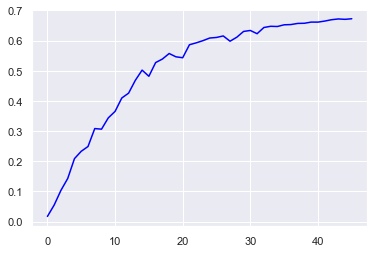

In [7]:
plt.plot(i_beta_32_04, color='blue')

In [8]:
scio.savemat('./i_beta_32_04.mat', {'i_beta_32_04': i_beta_32_04})